# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## Подготовка данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve 

import warnings
warnings.simplefilter('ignore')

In [2]:
data = pd.read_csv('/datasets/Churn.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             9091 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [3]:
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [4]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
RowNumber,10000.0,5.000500e+03,2886.895680,1.00,2500.75,5.000500e+03,7.500250e+03,10000.00
CustomerId,10000.0,1.569094e+07,71936.186123,15565701.00,15628528.25,1.569074e+07,1.575323e+07,15815690.00
CreditScore,10000.0,6.505288e+02,96.653299,350.00,584.00,6.520000e+02,7.180000e+02,850.00
Age,10000.0,3.892180e+01,10.487806,18.00,32.00,3.700000e+01,4.400000e+01,92.00
Tenure,9091.0,4.997690e+00,2.894723,0.00,2.00,5.000000e+00,7.000000e+00,10.00
Balance,10000.0,7.648589e+04,62397.405202,0.00,0.00,9.719854e+04,1.276442e+05,250898.09
NumOfProducts,10000.0,1.530200e+00,0.581654,1.00,1.00,1.000000e+00,2.000000e+00,4.00
HasCrCard,10000.0,7.055000e-01,0.455840,0.00,0.00,1.000000e+00,1.000000e+00,1.00
IsActiveMember,10000.0,5.151000e-01,0.499797,0.00,0.00,1.000000e+00,1.000000e+00,1.00
EstimatedSalary,10000.0,1.000902e+05,57510.492818,11.58,51002.11,1.001939e+05,1.493882e+05,199992.48


In [5]:
data[data['Tenure'].isna() == True].head(10)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
30,31,15589475,Azikiwe,591,Spain,Female,39,NaN,0.00,3,1,0,140469.38,1
48,49,15766205,Yin,550,Germany,Male,38,NaN,103391.38,1,0,1,90878.13,0
51,52,15768193,Trevisani,585,Germany,Male,36,NaN,146050.97,2,0,0,86424.57,0
53,54,15702298,Parkhill,655,Germany,Male,41,NaN,125561.97,1,0,0,164040.94,1
60,61,15651280,Hunter,742,Germany,Male,35,NaN,136857.00,1,0,0,84509.57,0
82,83,15641732,Mills,543,France,Female,36,NaN,0.00,2,0,0,26019.59,0
85,86,15805254,Ndukaku,652,Spain,Female,75,NaN,0.00,2,1,1,114675.75,0
94,95,15676966,Capon,730,Spain,Male,42,NaN,0.00,2,0,1,85982.47,0
99,100,15633059,Fanucci,413,France,Male,34,NaN,0.00,2,0,0,6534.18,0
111,112,15665790,Rowntree,538,Germany,Male,39,NaN,108055.10,2,1,0,27231.26,0


В колонке Tenure есть пропуски. В строках с пропусками есть клиенты, которые как являются кликентами банка, так и те, кто покинул его. Недостаточно информации, чтобы отнести эти записи к какому-то из существаующих Tenure. Присвоим этим записям новый Tenure = 11. 

In [6]:
data.loc[data['Tenure'].isna() == True, 'Tenure'] = 11

В датасете есть колонки RowNumber , CustomerId, Surname. Эти данные не влияют на поведение клиента, поэтому мы их удалим перед обучением модели.

In [7]:
data = data.drop(['RowNumber','CustomerId','Surname'], axis=1)

Преобразуем категориальные признаки техникой OHE.

In [8]:
data = pd.get_dummies(data, drop_first = True)

## Исследование задачи

Посмотрим баланс классов

In [9]:
data['Exited'].value_counts(normalize=True)

0    0.7963
1    0.2037
Name: Exited, dtype: float64

Наблюдается дисбаланс: клиенты , которые покинули банк занимают лишь 20% датасета. Вначале обучим модели без учета дисбаланса классов

### Разобьем данные на выборки

Разделим данные в следующей пропорции
- Обучающая выборка - 60%
- Валидационная выборка - 20%
- Тестовая выборка - 20%

In [10]:
df_train, df_valid_test = train_test_split(data, test_size=0.4, random_state=12345, stratify = data['Exited']) 
df_valid, df_test = train_test_split(df_valid_test,test_size=0.5, random_state=12345, stratify = df_valid_test['Exited'])

Сохраним признаки в отдельных переменных

In [11]:
features_train = df_train.drop('Exited', axis=1)
target_train = df_train['Exited']

features_valid = df_valid.drop('Exited', axis=1)
target_valid = df_valid['Exited']

features_test = df_test.drop('Exited', axis=1)
target_test = df_test['Exited']

print(features_train.shape,target_train.shape)
print(features_valid.shape,target_valid.shape)
print(features_test.shape,target_test.shape)

(6000, 11) (6000,)
(2000, 11) (2000,)
(2000, 11) (2000,)


Приведем численные признаки к одному масштабу.

In [12]:
numeric = ['CreditScore','Age','Tenure','Balance','EstimatedSalary','NumOfProducts']
scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

- ### Модель решающего дерева

In [13]:
best_result = 0
best_depth = 0
for depth in range(1, 16):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model.fit(features_train, target_train) # обучим модель
    predictions = model.predict(features_valid) # получим предсказания модели
    result = f1_score(target_valid, predictions) # посчитаем F1-меру модели на валидационной выборке
    if result > best_result:
        best_result = result
        best_depth = depth

        
print("F1-мера лучшей модели решающего дерева:", best_result)
print("Глубина дерева", best_depth)

F1-мера лучшей модели решающего дерева: 0.5928057553956835
Глубина дерева 7


Проверим AUC-ROC и F1-меру на тестовой выборке

In [14]:
model = DecisionTreeClassifier(random_state=12345, max_depth=best_depth)
model.fit(features_train, target_train)

probabilities_test = model.predict_proba(features_test)
probabilities_one_valid = probabilities_test[:, 1]

auc_roc = roc_auc_score(target_test, probabilities_one_valid)

print("AUC-ROC :",auc_roc)

predictions = model.predict(features_test)
print("F1-мера :",f1_score(target_test, predictions))

AUC-ROC : 0.8104691748759545
F1-мера : 0.5525525525525525


AUC-ROC выше 0,5 , значит модель считает лучше случайной модели. F1-мера ниже 0,59 - тест не пройден.

- ### Модель случайный лес

In [15]:
best_result = 0
best_depth = 0
for depth in range(1, 16):
    model = RandomForestClassifier(random_state=12345, n_estimators=20, max_depth=depth) 
    model.fit(features_train, target_train)
    predictions = model.predict(features_valid) # получим предсказания модели
    result = f1_score(target_valid, predictions) # посчитаем f1-меру модели на валидационной выборке
    if result > best_result:
        best_result = result
        best_depth = depth
        
best_result = 0               
for est in range(10, 100, 10):
    model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=best_depth) 
    model.fit(features_train, target_train)
    predictions = model.predict(features_valid) # получим предсказания модели
    result = f1_score(target_valid, predictions) # посчитаем f1-меру модели на валидационной выборке
    if result > best_result:
        best_result = result
        best_est = est

print("F1-мера лучшей модели случайного леса:", best_result)
print("n_estimators лучшей модели", best_est)
print("depth лучшей модели", best_depth)

F1-мера лучшей модели случайного леса: 0.6204819277108433
n_estimators лучшей модели 50
depth лучшей модели 14


Проверим AUC-ROC и F1-меру на тестовой выборке

In [16]:
model = RandomForestClassifier(random_state=12345, n_estimators=best_est, max_depth=best_depth)
model.fit(features_train, target_train)

probabilities_test = model.predict_proba(features_test)
probabilities_one_valid = probabilities_test[:, 1]

auc_roc = roc_auc_score(target_test, probabilities_one_valid)

print("AUC-ROC :",auc_roc)

predictions = model.predict(features_test)
print("F1-мера :",f1_score(target_test, predictions))

AUC-ROC : 0.8465723041994229
F1-мера : 0.5560675883256528


AUC-ROC выше 0,5 , значит модель считает лучше случайной модели. F1-мера ниже 0,59 - тест не пройден.

- ### Модель логистической регрессии

In [17]:
model = LogisticRegression(random_state=12345)
model.fit(features_train, target_train)
predictions = model.predict(features_valid) 
result = f1_score(target_valid, predictions)

probabilities_test = model.predict_proba(features_test)
probabilities_one_valid = probabilities_test[:, 1]

auc_roc = roc_auc_score(target_test, probabilities_one_valid)

print("F1-мера модели логистической регрессии на валидационной выборке:", result)
print("AUC-ROC :",auc_roc)

F1-мера модели логистической регрессии на валидационной выборке: 0.30965391621129323
AUC-ROC : 0.7504407334915809


AUC-ROC выше 0,5 , значит модель считает лучше случайной модели. F1-мера ниже 0,59 - тест на валидационной выборке не пройден.

## Борьба с дисбалансом

Создадим функцию для увеличения выборки

In [18]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    features_upsampled = shuffle(pd.concat([features_zeros] + [features_ones] * repeat),
                                 random_state=12345)
    target_upsampled = shuffle(pd.concat([target_zeros] + [target_ones] * repeat),
                               random_state=12345)
    return features_upsampled, target_upsampled

Уберем дисбаланс классов на тестовой выборке

In [19]:
target_train.value_counts(normalize=True)

0    0.796333
1    0.203667
Name: Exited, dtype: float64

In [20]:
features_train_upsampled, target_train_upsampled = upsample(features_train, target_train, 4)

In [21]:
target_train_upsampled.value_counts(normalize=True)

1    0.50569
0    0.49431
Name: Exited, dtype: float64

Найдем лучшую модель на сбалансированной тестовой выборке

- ### Модель решающего дерева

In [22]:
best_result = 0
best_depth = 0
for depth in range(1, 16):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model.fit(features_train_upsampled, target_train_upsampled) # обучим модель
    predictions = model.predict(features_valid) # получим предсказания модели
    result = f1_score(target_valid, predictions) # посчитаем F1-меру модели на валидационной выборке
    if result > best_result:
        best_result = result
        best_depth = depth

        
print("F1-мера лучшей модели решающего дерева:", best_result)
print("Глубина дерева", best_depth)

F1-мера лучшей модели решающего дерева: 0.575925925925926
Глубина дерева 6


На валидационной выборке f1-мера ниже 0,59. Модель не подходит

- ### Модель случайный лес

Подберем параметры n_estimators и max_depth совместно 

In [23]:
best_result = 0
best_depth = 0
for depth in range(1, 20):
    for est in range(10, 100,10): 
        model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth) 
        model.fit(features_train_upsampled, target_train_upsampled)
        predictions = model.predict(features_valid) # получим предсказания модели
        result = f1_score(target_valid, predictions) # посчитаем f1-меру модели на валидационной выборке
        if result > best_result:
            best_result = result
            best_depth = depth
            best_est = est

print("F1-мера лучшей модели случайного леса:", best_result)
print("n_estimators лучшей модели", best_est)
print("depth лучшей модели", best_depth)

F1-мера лучшей модели случайного леса: 0.6475138121546961
n_estimators лучшей модели 70
depth лучшей модели 10


- ### Модель логистической регрессии

Попробуем спользовать несбалансированную выборку и параметр class_weight='balanced' как метод борьбы с дисбалансом

In [24]:
model = LogisticRegression(random_state=12345, class_weight='balanced')
model.fit(features_train, target_train)
predictions = model.predict(features_valid) 
result = f1_score(target_valid, predictions)

print("F1-мера модели логистической регрессии на валидационной выборке:", result)

F1-мера модели логистической регрессии на валидационной выборке: 0.5285338015803336


Теперь попробуем на сбалансированной выборке

In [25]:
model = LogisticRegression(random_state=12345, class_weight='balanced')
model.fit(features_train_upsampled, target_train_upsampled)
predictions = model.predict(features_valid) 
result = f1_score(target_valid, predictions)

print("F1-мера модели логистической регрессии на валидационной выборке:", result)

F1-мера модели логистической регрессии на валидационной выборке: 0.5285338015803336


На валидационной выборке f1-мера ниже 0,59. Модель не подходит

## Тестирование модели

На валидационной выборке значение f1-меры выше 0,59 было только у модели случайного леса. Проверим модель на тестовой выборке.

In [26]:
# model = RandomForestClassifier(random_state=12345, n_estimators=34, max_depth=11) 
model = RandomForestClassifier(random_state=12345, n_estimators=70, max_depth=10) 
model.fit(features_train_upsampled, target_train_upsampled)
predictions = model.predict(features_test)

probabilities_test = model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]

auc_roc = roc_auc_score(target_test, probabilities_one_test)

print("AUC-ROC :",auc_roc)
print("F1-мера :",f1_score(target_test, predictions))

AUC-ROC : 0.8517438856421907
F1-мера : 0.5995525727069352


F1-мера выше 0,59 на тестовой выборке. Цель проекта достигнута. 

Визуализируем ROC-кривую. 

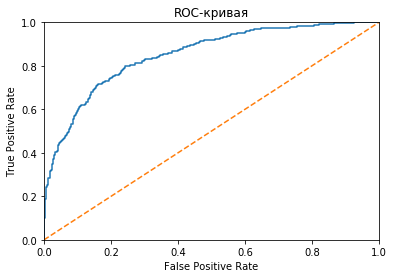

In [27]:
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test) 

plt.figure()
plt.plot(fpr, tpr)

# ROC-кривая случайной модели (выглядит как прямая)
plt.plot([0, 1], [0, 1], linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')

plt.show()

## Общий вывод

По итогам обучения моделей без учета дисбаланса классов на валидационной выборке f1-меру выше 0.59 показали модели решающего дерева и случайного леса. Однако при проверке на тестовой выборке f1-мера была на уровне 0.55 и тест был не пройден. При этом AUC-ROC стабильно был на уровне 0.8-0.85.

После балансировки классов на валидационной выборке f1-меру выше 0.59 показала только модель случайного леса. При проверке на тестовой выборке значение f1-меры было также выше 0.59. Параметры модели, которая прошла тестовую выборку:

RandomForestClassifier(random_state=12345, n_estimators=70, max_depth=10)